# degaussing_demo.ipynb
This notebook demonstrates the use of `rshyst` to simulate degaussing for a simple electromagnet composed of a wire-wrapped ferromagnetic core.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from electromagnet import Electromagnet
from rshyst import JilesAtherton, constants

## Creating a hysteresis model
In the following cell, we use `rshyst` to define a Jiles-Atherton magnetic hysteresis model:

In [2]:
# Set Jiles-Atherton model parameters for low-carbon steel
ja_params = {
    'dH' : 1.,
    'sat_tol': 2.5e-4,
    'alpha': 4.93e-4,
    'a': 399,
    'Ms': 1.35e6,
    'k': 300,
    'c': 0.120,
    'integrator' : 'RK45',
}

# Construct the Jiles-Atherton hysteresis model
ja_model = JilesAtherton(**ja_params)

## Creating a simple electromagnet
Next we create a simple electromagnet composed of a ferromagnetic core wrapped in a solenoid:

In [3]:
magnet_params = {
    "turns": 100.,
    "M0": 0.,
    "I0": 0.,
    "hyst_model": ja_model
}
magnet = Electromagnet(**magnet_params)

## Defining applied currents
Now we'll define a time series of currents to apply to the solenoid. The current is raised to bring the electromagnet to a fully magnetized state and then lowered to zero, leaving the electromagnet with a remanent magnetization. Finally, an oscillating field is applied in an attempt to remove the remanent magnetization.

In [4]:
# Describes an applied current profile for simulating degaussing
def I_app(t, t0h, t1h, t0d, I0h, I0d, w, f, rho):
    
    # Current applied to reach fully magnetized state
    Im = I0h*(1/(1+np.exp(rho*(t0h-t)))+1/(1+np.exp(rho*(t-t1h)))-1)
    
    # Oscillating current applied during degaussing
    Id = (I0d*np.exp(-w*(t-t0d))*np.cos(2*np.pi*f*(t-t0d)))/(1+np.exp(-rho*(t-t0d)))
    
    return Im+Id

# Define time parameters
t0h = 0.5 # Hysteretic current switch-on midpoint
t1h = 1 # # Hysteretic current switch-off midpoint
t0d = 2 # Degaussing switch-on
tmax = 5 # Maximum simulation time

# Define current parameters
I0h = 30 # Applied current reaching hysteretic state
I0d = 1 # Maximum applied current during degaussing
rho = 50 # Current switching rate 
f = 10 # Current oscillation frequency during degaussing
w = 5 # Current decay parameter during degaussing

# Define applied currents over a specified range of times
ts = np.array(range(0, 1000))*tmax/1000
Ia = I_app(ts, t0h, t1h, t0d, I0h, I0d, w, f, rho)

To get a better feel for what the applied current is doing, we can plot the current profile versus time:

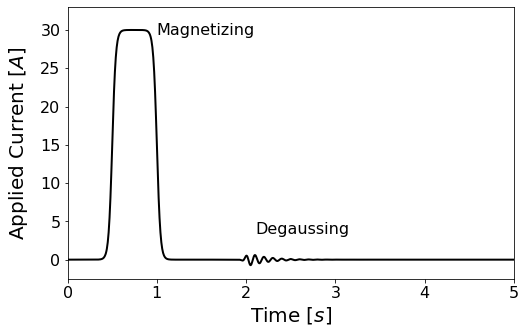

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ts, Ia,'k', lw=2)
ax.text(1, I0h, "Magnetizing", va='center', ha='left', color='k', fontsize=16)
ax.text(2.1, I0h/7.5, "Degaussing", va='center', ha='left', color='k', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_xlabel("Time [$s$]", fontsize=20)
ax.set_ylabel("Applied Current [$A$]", fontsize=20, labelpad=10)
plt.axis([0, 5 , -2.5*I0d, 1.1*Ia.max()])
plt.show()

## Simulating degaussing
We now have all we need to simulate degaussing. In the cell below, we iterate through the series of applied currents and compute the resulting magnetization in the electromagnet, storing the values for plotting.

In [6]:
Hs = []
Ms = []
for I in Ia:
    magnet.apply_current(I)
    Hs.append(magnet.H)
    Ms.append(magnet.M)

Hs = np.array(Hs) * constants.MU0
Ms = np.array(Ms) * constants.MU0

Now let's ...

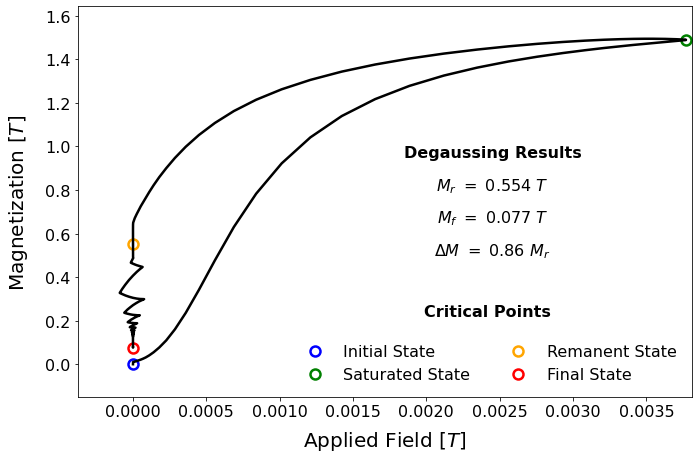

In [7]:
# Define useful quantities for plotting
tSat = int(np.where(ts == (t0h + t1h) / 2)[0])     # Timestep for saturation
tRem = int(np.where(ts == (t1h + t0d) / 2)[0])   # Timestep for remanence
rDG = (1 - abs(Ms[-1]) / Ms[tRem])   # Ratio of magnetization removed

# Plot the degaussing results, marking & labeling critical points
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(Hs[0], Ms[0], 'bo', mfc='none', ms=10, mew=2.5, label='Initial State')
ax.plot(Hs[tSat], Ms[tSat], 'go', mfc='none', ms=10, mew=2.5, label='Saturated State')
ax.plot(Hs[tRem], Ms[tRem], 'o', color='orange', mfc='none', ms=10, mew=2.5, label='Remanent State')
ax.plot(Hs[-1], Ms[-1], 'ro', mfc='none', ms=10, mew=2.5, label='Final State')
leg = ax.legend(loc='lower right', fontsize=16, ncol=2, framealpha=0)
leg.set_title("Critical Points\n", prop={"size":16, "weight":"bold"})
ax.plot(Hs, Ms, 'k', lw=2.5)
ax.text(.65*Hs.max(), .65*Ms.max(), r"Degaussing Results", ha='center', va='center', fontsize=16, weight="bold")
ax.text(.65*Hs.max(), .55*Ms.max(), r"$M_r\ =\ {:.3f}\ T$".format(Ms[tRem]), ha='center', va='center', fontsize=16)
ax.text(.65*Hs.max(), .45*Ms.max(), r"$M_f\ =\ {:.3f}\ T$".format(Ms[-1]), ha='center', va='center', fontsize=16)
ax.text(.65*Hs.max(), .35*Ms.max(), r"$\Delta M\ =\ {:.2f}\ M_r$".format(rDG), ha='center', va='center', fontsize=16)
ax.axis([-.1*Hs.max(), 1.01*Hs.max(), -.1*Ms.max(), 1.1*Ms.max()])
ax.set_xlabel(r"Applied Field [$T$]", fontsize=20, labelpad=10)
ax.set_ylabel(r"Magnetization [$T$]",fontsize=20, labelpad=15)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)

## Degaussing vs. applied current
The following cells repeat the process shown above for many values of the initial degaussing current, ``I0d``.

In [8]:
rDGs = []
I0ds = 1.e-3 + 5. * np.array(range(51))/50
for i in range(len(I0ds)):
    magnet.H = magnet.M = 0.
    Ia = I_app(ts, t0h, t1h, t0d, I0h, I0ds[i], w, f, rho)
    loopHs = []
    loopMs = []
    for I in Ia:
        magnet.apply_current(I)
        loopHs.append(magnet.H)
        loopMs.append(magnet.M)
    
    rDGs.append(1. - abs(loopMs[-1]) / loopMs[tRem])

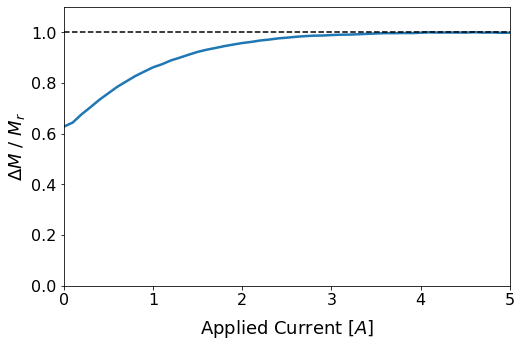

In [9]:
# Plot the example hysteresis quantities for the Jiles-Atherton model
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(I0ds, rDGs,lw=2.5)
ax.plot([0, I0ds.max()],[1., 1.], 'k--')
ax.axis([0, I0ds.max(), 0, 1.1])
ax.set_ylabel(r"$\Delta M\ /\ M_r$",fontsize=18)
ax.set_xlabel(r"Applied Current [$A$]", fontsize=18, labelpad=10)
ax.tick_params(labelsize=16)
fig.subplots_adjust(top=.9)